In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns # for beautiful graphs
import scipy.stats as stats # to calculate r^2 for linear regressions
from scipy.stats import powerlaw # for plotting linear regressions
import statsmodels as sm
import matplotlib.ticker as mtick
import re
sns.set()
import warnings
warnings.filterwarnings('ignore')

In [7]:
#opening the data
data= pd.read_csv('clean_dataset.csv',delimiter=',')

# drop the unnamed column
data.drop(['Unnamed: 0'], axis=1,inplace=True)


In [8]:
#show the dataframe
display(data.head(3))

,inspection_id,dba_name,aka_name,license,facility_type,risk,address,zip,inspection_date,inspection_type,results,violations,latitude,longitude,location
0,2320342,YOLK TEST KITCHEN,YOLK TEST KITCHEN,2589655.0,Restaurant,Risk 1 (High),1767 N MILWAUKEE AVE,60647.0,2019-10-23,Canvass,Pass w/ Conditions,23. PROPER DATE MARKING AND DISPOSITION - Comm...,41.913588,-87.682203,"{'longitude': '41.9135877900482', 'latitude': ..."
1,2320261,CRAZY BIRD,CRAZY BIRD,2616198.0,Restaurant,Risk 1 (High),1160 W GRAND AVE,60642.0,2019-10-22,Canvass,Pass w/ Conditions,16. FOOD-CONTACT SURFACES: CLEANED & SANITIZED...,41.891193,-87.657055,"{'longitude': '41.891193484441246', 'latitude'..."
2,2320298,HAISOUS,CA PHE DA,2464411.0,Restaurant,Risk 1 (High),1800-1802 S CARPENTER ST,60608.0,2019-10-22,Canvass,Pass,47. FOOD & NON-FOOD CONTACT SURFACES CLEANABLE...,41.857963,-87.653358,"{'longitude': '41.8579631274509', 'latitude': ..."


# Violation characterization 

In [89]:
#function that split the violations number from the comments

def violation_separator(violations):
    
    #creating an empty dataframe in order to stock the violation numbers
    violation_number = pd.Series([]) 
    
    if type(violations) == str:
        #each different violation is separated by a ' | ' in a dataframe cell
        violations = violations.split(' | ') 
       
        for violation in violations: 
            #the index refers to the violation number
            index = "#" + violation.split('.')[0] 
            #add 1 if there is a violation #.. and 0 if not.
            violation_number[index] = 1
            
    return violation_number

In [90]:
# function that take a data with  violations by number and categorize them and count then by category
def Violations_Dataframe (separated_data, basic_data): 
    
    #columns creation 
    critical = [("#" + str(num)) for num in range(1, 15)]
    serious = [("#" + str(num)) for num in range(15, 30)]
    minor = [("#" + str(num)) for num in range(30, 45)]
    minor.append("#70")

    # Create complete list of column names
    columns = critical + serious + minor

    # Create dataframe using column names, violation data and inspection ID
    violations_data = pd.DataFrame(separated_data, columns=columns)
    violations_data['inspection_id'] = basic_data.inspection_id
    violations_data['license'] = basic_data.license
    
    violation_counts = pd.DataFrame({
    "critical_count": violations_data[critical].sum(axis=1),
    "serious_count": violations_data[serious].sum(axis=1),
    "minor_count": violations_data[minor].sum(axis=1)
    })

    violation_counts['inspection_id'] = basic_data.inspection_id
    violation_counts['license'] = basic_data.license
    violation_counts['zip'] = basic_data.zip
    violation_counts['risk'] = basic_data.risk
    violation_counts['results'] = basic_data.results
    violation_counts['inspection_type'] = basic_data.inspection_type
    # Display selection of sums dataframe
    violation_counts.iloc[3:6]
    
    return violation_counts

In [91]:
#We apply this functions to our basic data 
violation_separated= data.violations.apply(violation_separator).fillna(0)

In [92]:
#we create our dataframe with all the violations counts
violations_dataframe=Violations_Dataframe(violation_separated,data)

In [93]:
violations_dataframe.head(5)

,critical_count,serious_count,minor_count,inspection_id,license,zip,risk,results,inspection_type
0,0.0,2.0,1.0,2320342,2589655.0,60647.0,Risk 1 (High),Pass w/ Conditions,Canvass
1,0.0,2.0,1.0,2320261,2616198.0,60642.0,Risk 1 (High),Pass w/ Conditions,Canvass
2,0.0,0.0,0.0,2320298,2464411.0,60608.0,Risk 1 (High),Pass,Canvass
3,0.0,0.0,1.0,2320293,61757.0,60638.0,Risk 1 (High),Fail,Complaint Re-Inspection
4,1.0,1.0,1.0,2320229,2670751.0,60625.0,Risk 1 (High),Pass w/ Conditions,Canvass


# Applied Machine Learning ( parameters exploration)

In [52]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import re
from sklearn.model_selection import train_test_split, validation_curve, cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

> We want to create a score. To do so, we need to know which paramater predict the most the inspection result. We will use the following parameters:
- Number of critical count
- Number of serious count
- Number of minor count
- region defined by the zip code 
- the risk


> The first step consist on converting all the variable to numerical values. (change the following columns : risk, zip,results)

In [19]:
violations_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133270 entries, 0 to 133269
Data columns (total 8 columns):
critical_count    133270 non-null float64
serious_count     133270 non-null float64
minor_count       133270 non-null float64
inspection_id     133270 non-null int64
license           133270 non-null float64
zip               133258 non-null float64
risk              133270 non-null object
results           133270 non-null object
dtypes: float64(5), int64(1), object(2)
memory usage: 8.1+ MB


> The columns with object dtype are the possible categorical features in your dataset.

In [26]:
work_mapper_risk = {'Risk 1 (High)':1,'Risk 2 (Medium)':2,'Risk 3 (Low)':3}
work_mapper_results = {'Pass':1,'Pass w/ Conditions':0,'Fail':-1}

# Replace them in the dataframe
violations_dataframe['risk'] = violations_dataframe['risk'].replace(work_mapper_risk).astype(int)
violations_dataframe['results'] = violations_dataframe['results'].replace(work_mapper_results).astype(int)

In [27]:
violations_dataframe.head(3)

,critical_count,serious_count,minor_count,inspection_id,license,zip,risk,results
0,0.0,2.0,1.0,2320342,2589655.0,60647.0,1,0
1,0.0,2.0,1.0,2320261,2616198.0,60642.0,1,0
2,0.0,0.0,0.0,2320298,2464411.0,60608.0,1,1


In [28]:
# Features
features = ['risk','critical_count','serious_count','minor_count']

# Target dataframe (overall score)
target_df = violations_dataframe.results

# Features dataframe
features_df = violations_dataframe[features]

features_df.head()

,risk,critical_count,serious_count,minor_count
0,1,0.0,2.0,1.0
1,1,0.0,2.0,1.0
2,1,0.0,0.0,0.0
3,1,0.0,0.0,1.0
4,1,1.0,1.0,1.0


In [37]:
dataframe_target_features=features_df.copy()
dataframe_target_features['results']=violations_dataframe.results

# Display the correlation among the columns using pearson method 
corr = dataframe_target_features.corr(method ='pearson')

# Visualize the correlation (sorted) between each feature and the 'Overall' performance
corr[['results']].sort_values(by=['results'], ascending = False)

,results
results,1.000000
risk,0.002659
minor_count,-0.167410
critical_count,-0.458776
serious_count,-0.729299


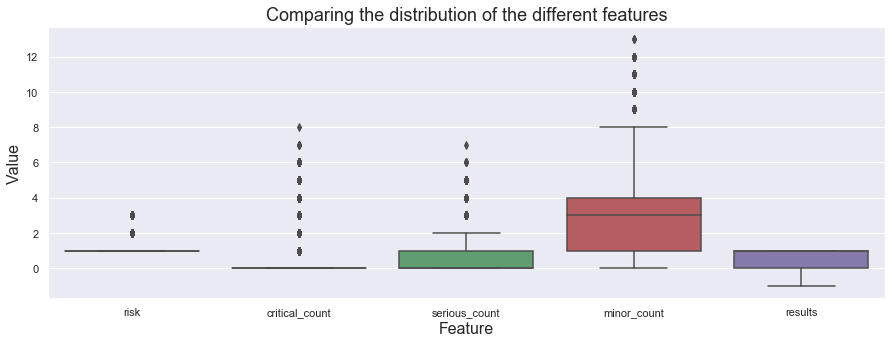

In [41]:
plt.figure(figsize=(15,5))

# Extract the parameters of interests from the dataframe
ax = sns.boxplot(x="variable", y="value", data=pd.melt(dataframe_target_features))

# Set the labels and plot
ax.set_xlabel(xlabel="Feature", fontsize=16)
ax.set_ylabel(ylabel='Value', fontsize=16)
ax.set_title(label='Comparing the distribution of the different features', fontsize=18)
plt.show()

In [42]:
from sklearn import preprocessing
import numpy as np

In [48]:
 X_scaled = preprocessing.scale(dataframe_target_features)
scaled_dataframe=pd.DataFrame(X_scaled,columns=dataframe_target_features.columns)
scaled_dataframe.head(3)

,risk,critical_count,serious_count,minor_count,results
0,-0.509024,-0.45525,2.299578,-0.860835,-0.530372
1,-0.509024,-0.45525,2.299578,-0.860835,-0.530372
2,-0.509024,-0.45525,-0.526610,-1.325596,0.719035


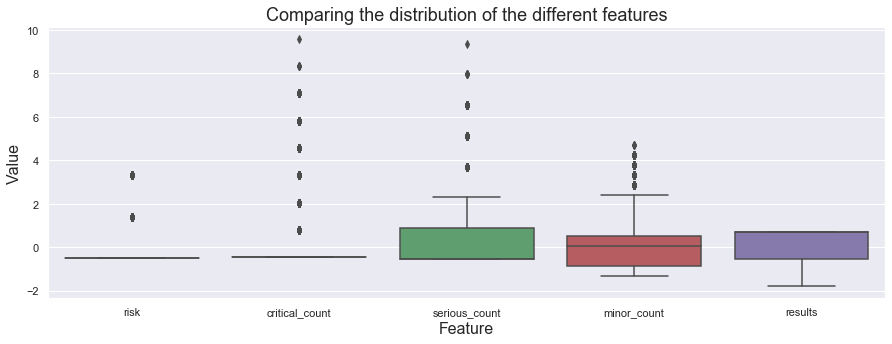

In [50]:
plt.figure(figsize=(15,5))

# Extract the parameters of interests from the dataframe
ax = sns.boxplot(x="variable", y="value", data=pd.melt(scaled_dataframe))

# Set the labels and plot
ax.set_xlabel(xlabel="Feature", fontsize=16)
ax.set_ylabel(ylabel='Value', fontsize=16)
ax.set_title(label='Comparing the distribution of the different features', fontsize=18)
plt.show()

In [54]:
def plot_hist(x_data, n_bins, kde_ = False, x_label = '', y_label = '', title = ''):
    '''
    Plot a histogram of a given column in a dataframe 
    given a fixed number of bins.
    :param x_data: pandas.Series
    :param n_bins: int
    :params x_label, y_label, title: string
    :param kde_: bool
    '''
    # Set the seaborn parameters
    sns.set(style ="dark", palette="colorblind", color_codes=True)

    # Extract our parameter of interest
    x = x_data
    plt.figure(figsize=(12,5))
    
    # Set the bins parameters and plot (or not) a gaussian density estimate.
    if(kde_ == False):
        ax = sns.distplot(x, bins = n_bins, kde = kde_, color='g')  
    else:
        ax = sns.distplot(x, bins = n_bins, kde = kde_, color='g')

    # Set the labels
    ax.set_xlabel(xlabel = x_label, fontsize=16)
    ax.set_ylabel(ylabel = y_label, fontsize=16)
    ax.set_title(label = title, fontsize=20)

    plt.show()

In [62]:
dataframe_target_features['minor_count'].nunique()

14

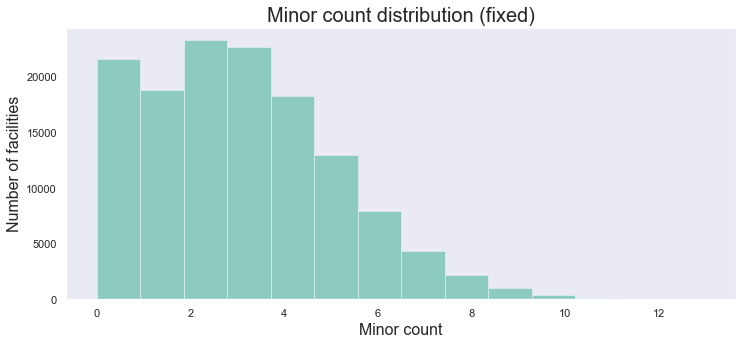

In [69]:
plot_hist(dataframe_target_features['minor_count'],14 , x_label='Minor count', y_label='Number of facilities', title='Minor count distribution (fixed)')

In [70]:
dataframe_target_features['serious_count'].nunique()

8

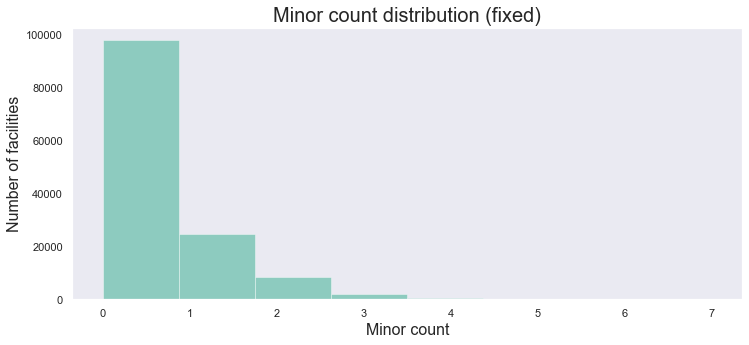

In [71]:
plot_hist(dataframe_target_features['serious_count'],8 , x_label='Minor count', y_label='Number of facilities', title='Minor count distribution (fixed)')

In [72]:
dataframe_target_features['critical_count'].nunique()

9

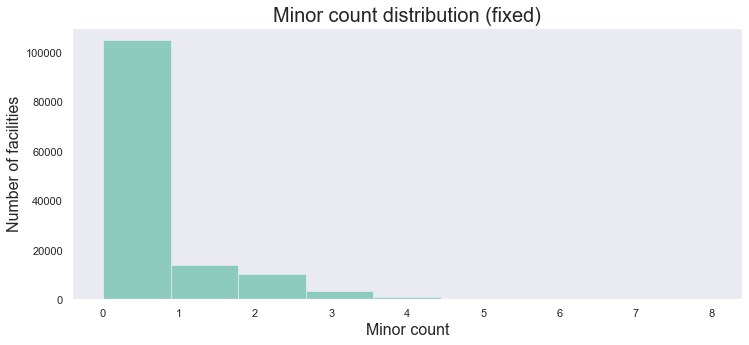

In [74]:
plot_hist(dataframe_target_features['critical_count'],9 , x_label='Minor count', y_label='Number of facilities', title='Minor count distribution (fixed)')

>  The 3 distributions of count data are positively skewed with many observations in the data set having a value of 0. The high number of 0’s in the data set prevents the transformation of a skewed distribution into a normal one. Second, it is quite likely that the regression model will produce negative predicted values, which are theoretically impossible.

Text(0.04, 0.5, 'Number of facilities')

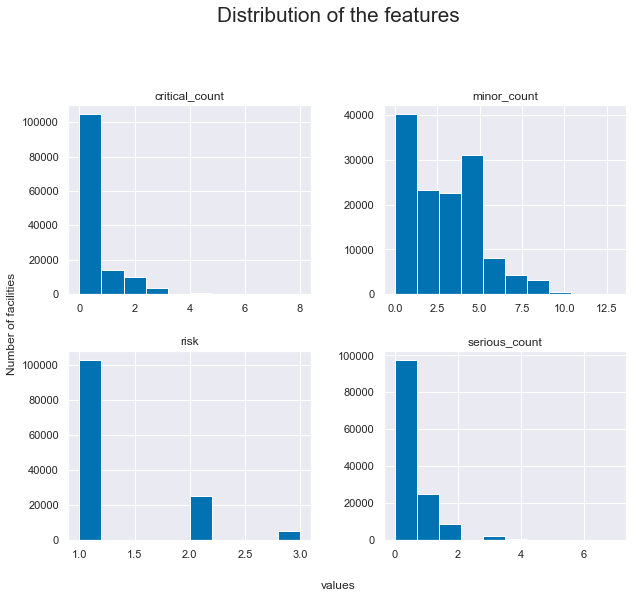

In [76]:
# Set up figure and axes
fig, axes = plt.subplots(sharex=True, sharey=True,figsize = (10,8))

# Plot each column as a histogram with bins=20
features_df.hist(ax=fig.gca(), bins=10)

# Set title and axis labels
plt.suptitle('Distribution of the features', x=0.5, y=1.05, ha='center', fontsize='xx-large')
fig.text(0.5, 0.04, 'values', ha='center')
fig.text(0.04, 0.5, 'Number of facilities', va='center', rotation='vertical')

In [84]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaled_ml_df = scaler.fit_transform(features_df)

scaled_ml_df=pd.DataFrame(scaled_ml_df,columns=features_df.columns)

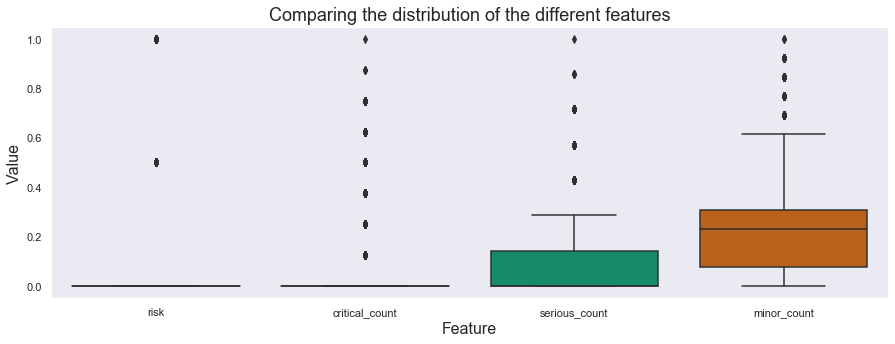

In [85]:
plt.figure(figsize=(15,5))

# Extract the parameters of interests from the dataframe
ax = sns.boxplot(x="variable", y="value", data=pd.melt(scaled_ml_df))

# Set the labels and plot
ax.set_xlabel(xlabel="Feature", fontsize=16)
ax.set_ylabel(ylabel='Value', fontsize=16)
ax.set_title(label='Comparing the distribution of the different features', fontsize=18)
plt.show()

Text(0.04, 0.5, 'Number of facilities')

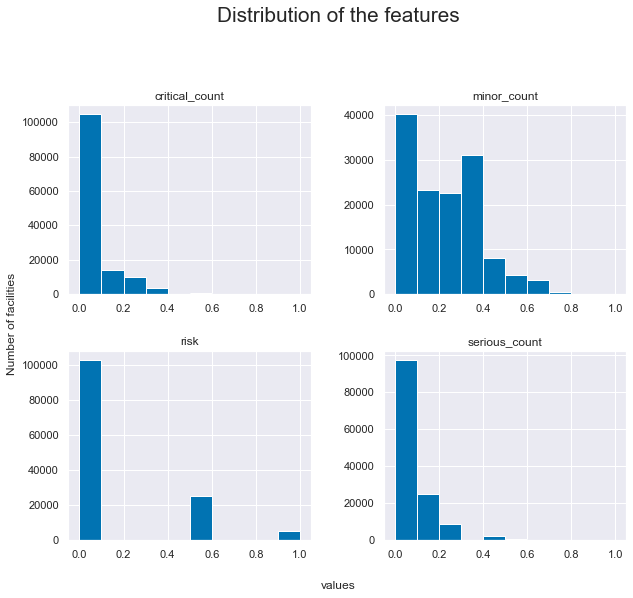

In [86]:
# Set up figure and axes
fig, axes = plt.subplots(sharex=True, sharey=True,figsize = (10,8))

# Plot each column as a histogram with bins=20
scaled_ml_df.hist(ax=fig.gca(), bins=10)

# Set title and axis labels
plt.suptitle('Distribution of the features', x=0.5, y=1.05, ha='center', fontsize='xx-large')
fig.text(0.5, 0.04, 'values', ha='center')
fig.text(0.04, 0.5, 'Number of facilities', va='center', rotation='vertical')

# Suspected Food Poisoning

In [98]:
food_poisoning_df=violations_dataframe.loc[violations_dataframe['inspection_type']== 'Suspected Food Poisoning']

In [99]:
food_poisoning_df.head(3)

,critical_count,serious_count,minor_count,inspection_id,license,zip,risk,results,inspection_type
152,0.0,0.0,0.0,2315831,37212.0,60642.0,Risk 1 (High),Pass,Suspected Food Poisoning
513,1.0,2.0,4.0,2312966,2428838.0,60622.0,Risk 1 (High),Fail,Suspected Food Poisoning
786,1.0,4.0,1.0,2312427,16310.0,60629.0,Risk 1 (High),Fail,Suspected Food Poisoning


In [105]:
food_poisoning_df['critical_count'].nunique()

7

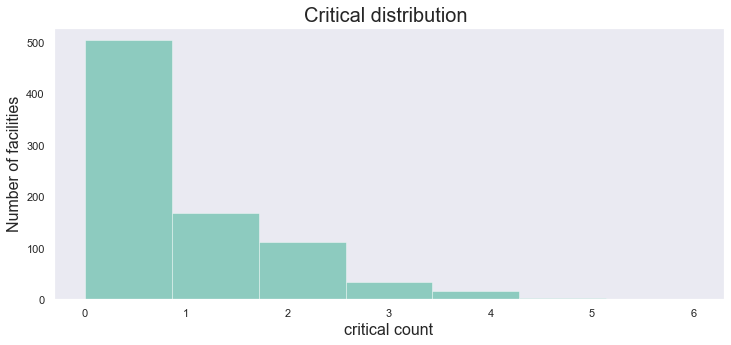

In [108]:
plot_hist(food_poisoning_df['critical_count'],7 , x_label='critical count', y_label='Number of facilities', title='Critical distribution ')

In [100]:
food_poisoning_df['serious_count'].nunique()

5

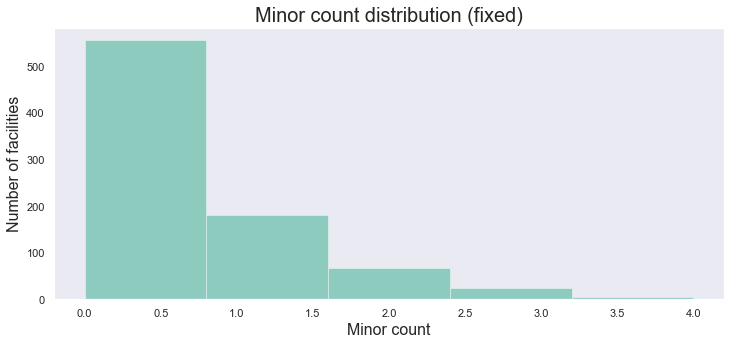

In [102]:
plot_hist(food_poisoning_df['serious_count'],5 , x_label='Serious count', y_label='Number of facilities', title='Serious count distribution')

In [103]:
food_poisoning_df['minor_count'].nunique()

12

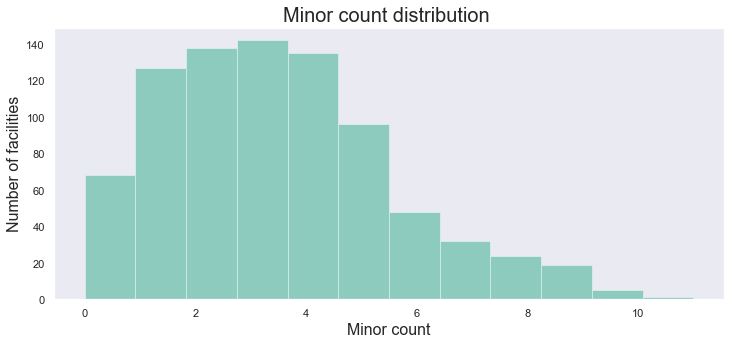

In [109]:
plot_hist(food_poisoning_df['minor_count'],12 , x_label='Minor count', y_label='Number of facilities', title='Minor count distribution ')